In this program, we inplement a simple Q-learning to train a trading strategy using simulated data and test using simulated data again in a very simple market.
The marke has following assumptions:
1. The market has only one single security. This market admits arbitrage, and the security price is not a martingale. 
2. The only security follows a standard O-U process, i.e, meaning reverting.
3. The trade size δnt in a single interval is limited to at most K round lots.The trade size δnt in a single interval is limited    to at most K round lots, which means the action space is LotSize·{-K, -K+1, ... , K-1, K}
4. Possible holding space is LotSize·{-M, -M+1, ... , M-1, M} and possible security prices is TickSize·{1,2,...1000}.
5. State space is holding space * security prices space whose cardinality is (2M+1)*1000 
6. There exists quadratic trading frictions, which is specified as following.
   SpreadCost(δn) = TickSize · |δn|
   ImpactCost(δn) = (δn)2 × TickSize/LotSize


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Parameters settings:

# Security process parameters:
lambda_ = np.log(2)/5
sigma = 0.1
pe = 50

# Market parameters:
LotSize = 100
TickSize = 0.1
K = 5
M = 10


# Q-learning parameters:
# Reward = P/L - 0.5*kappa*(P/L)^2
kappa = 0.0001
gamma = 0.999 # discount factor
alpha = 0.1 # learning rate
epsilon = 0.1 # epsilon greedy

In [3]:
# Generate next day price given current price
# Security Price follows a mean-reverting process where dpt = lambda(pe-pt)dt+sigma*dWt
def NextPrice(price, pe, lambda_, sigma):
    pricechange = lambda_*(pe - price) + sigma*np.random.normal()
    nextprice = round(price+pricechange, 1)
    return nextprice

In [4]:
# Reward Function
def Reward(delta_n, TickSize, LotSize, price, newprice, holding, kappa):
    SpreadCost = TickSize*abs(delta_n)
    ImpactCost = (delta_n**2)*TickSize/LotSize    
    pnl = holding*(newprice-price) - SpreadCost - ImpactCost
    reward = pnl - 0.5*kappa*(pnl**2)
    return reward

In [5]:
# Given a state, give an action corresponding to epsilon gready strategy
def epsilonGreedyAction(Q, epsilon,holdlot, pricetick):
    state = (holdlot, pricetick)
    actionspace = Q[state]
    optacts = actionspace[actionspace == actionspace.max()].index
    nonoptacts = actionspace[actionspace != actionspace.max()][actionspace[actionspace != actionspace.max()]>-np.inf].index
    unirand = np.random.uniform()
    if (unirand < (1-epsilon)):
        return np.random.choice(optacts)
    else:
        if len(nonoptacts) == 0:
            return np.random.choice(optacts)
        else:
            return np.random.choice(nonoptacts)

In [6]:
# Action Lot Space, Holding Lot Space, Price Tick Space and State Space 
ActionLotSpace = np.arange(-K,K+1)
HoldingLotSpace = np.arange(-M,M+1)
PriceTickSpace = np.arange(1,1001)
StateSpace = []
for holdlot in HoldingLotSpace:
    for pricetick in PriceTickSpace:
        StateSpace.append((holdlot,pricetick))

In [7]:
# Initialize Q where some part is -inf because of position limit
Q = pd.DataFrame(np.zeros((2*K+1,(2*M+1)*1000)),index=ActionLotSpace, columns=StateSpace)
for i in range(K,0,-1):
    Q.iloc[0:i,1000*(K-i):1000*(K-i+1)] = -np.inf
    Q.iloc[K+i:2*K+1,1000*(2*M+1-i):1000*(2*M+2-i)] = -np.inf

In [8]:
# Initialization
price = pe
pricetick = round(price/TickSize)
holding = 0
holdlot = 0

# Training using 1,000,000 periods
for i in range(1000000):
    
    # Stochastic action given Q and state
    action = epsilonGreedyAction(Q, epsilon, holdlot, pricetick)
    
    # Simulate security price
    newprice = NextPrice(price, pe, lambda_, sigma)
    newpricetick = round(newprice/TickSize)
    
    # New position corresponding to our action
    newholdlot = holdlot + action
    newholding = newholdlot*LotSize
    
    # Reward of action
    delta_n = action*LotSize
    R = Reward(delta_n, TickSize, LotSize, price, newprice, holding, kappa)
    
    # Update Q matrix
    Target = R + gamma*(Q[(newholdlot,newpricetick)].max())
    Q.loc[action][(holdlot,pricetick)] = (1-alpha)*Q.loc[action][(holdlot,pricetick)] + alpha*Target 
   
    # Update state
    price = newprice
    pricetick = newpricetick
    holding = newholding
    holdlot = newholdlot

In [9]:
# Initialization
price = pe
pricetick = round(price/TickSize)
holding = 0
holdlot = 0

PnL = []

# Testing using 500,000 simulated periods
for i in range(500000):
    
    # Stochastic action given Q and state
    action = epsilonGreedyAction(Q, epsilon, holdlot, pricetick)
    
    # Simulate security price
    newprice = NextPrice(price, pe, lambda_, sigma)
    newpricetick = round(newprice/TickSize)
    
    # New position corresponding to our action
    newholdlot = holdlot + action
    newholding = newholdlot*LotSize
    
    # P/L
    delta_n = action*LotSize
    SpreadCost = TickSize*abs(delta_n)
    ImpactCost = (delta_n**2)*TickSize/LotSize    
    pnl = holding*(newprice-price) - SpreadCost - ImpactCost
    PnL.append(-pnl)
    
    # Update state
    price = newprice
    pricetick = newpricetick
    holding = newholding
    holdlot = newholdlot

# Calculate cumulative PnL
PnL = np.cumsum(PnL)

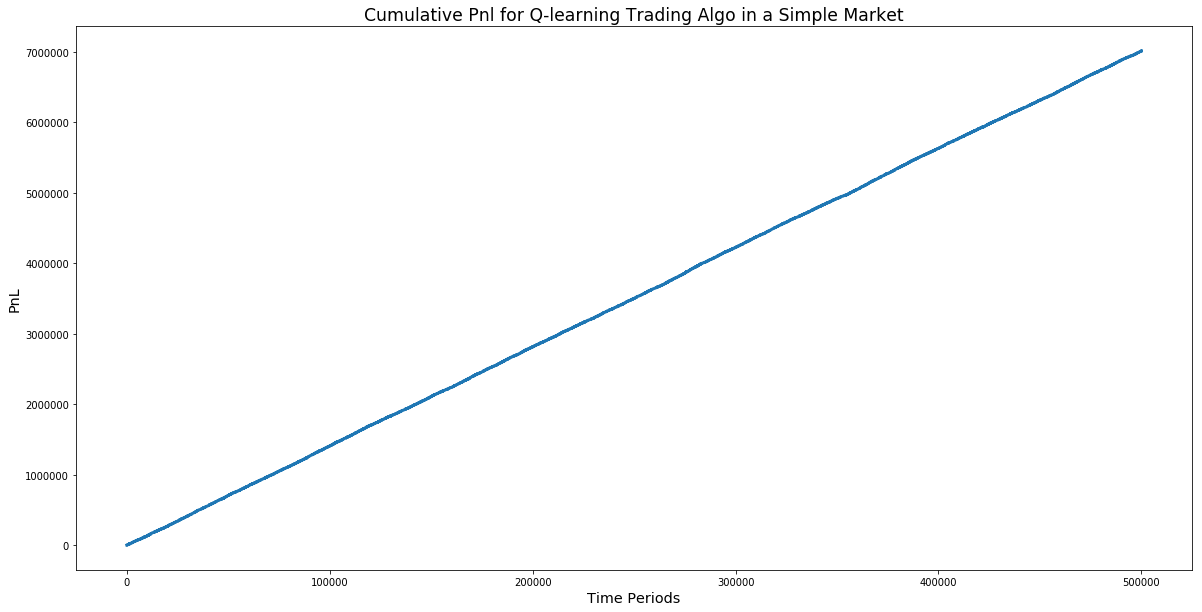

In [10]:
#plot cumulative PnL
plt.figure(figsize=(20,10))
plt.title('Cumulative Pnl for Q-learning Trading Algo in a Simple Market',fontsize='xx-large')
plt.xlabel('Time Periods',fontsize='x-large')
plt.ylabel('PnL',fontsize='x-large')
plt.plot(PnL,linewidth=3)
plt.show()

In [11]:
# Calculate returns
ret = pd.DataFrame(PnL).diff()
ret = ret.dropna().values

# Calculate Sharpe Ratio
Sharpe = np.sqrt(252)*ret.mean()/ret.std()
print('Sharpe Ratio is: ', Sharpe)

Sharpe Ratio is:  2.945614830868239
